In [52]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
from sklearn.metrics import classification_report 
from tqdm import tqdm
from decouple import config
import json
import re
import time
import matplotlib.pyplot as plt

In [9]:
# Read the CSV file for jobposts into a DataFrame
df_jobposts = pd.read_csv('data/processed/jobposts.csv')
df_jobposts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964 entries, 0 to 7963
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          7964 non-null   object
 1   country_code     7964 non-null   object
 2   date_added       49 non-null     object
 3   has_expired      7964 non-null   object
 4   job_board        7964 non-null   object
 5   job_description  7964 non-null   object
 6   job_title        7964 non-null   object
 7   job_type         7418 non-null   object
 8   location         7964 non-null   object
 9   organization     5616 non-null   object
 10  page_url         7964 non-null   object
 11  salary           1277 non-null   object
 12  sector           6131 non-null   object
 13  uniq_id          7964 non-null   object
 14  predictions      7964 non-null   object
dtypes: object(15)
memory usage: 933.4+ KB


In [10]:
# Count and list unique job categories
print(df_jobposts['predictions'].value_counts())

predictions
SALES                     1365
HEALTHCARE                1193
ENGINEERING               1107
INFORMATION-TECHNOLOGY    1056
CONSTRUCTION               710
CHEF                       419
ACCOUNTANT                 386
HR                         341
AUTOMOBILE                 283
ADVOCATE                   250
FINANCE                    211
BUSINESS-DEVELOPMENT       140
PUBLIC-RELATIONS           125
AGRICULTURE                 81
TEACHER                     68
AVIATION                    52
CONSULTANT                  42
APPAREL                     33
BANKING                     31
DESIGNER                    29
DIGITAL-MEDIA               27
FITNESS                     10
ARTS                         5
Name: count, dtype: int64


In [11]:
# Filter for the 5 target categories
categories = ['INFORMATION-TECHNOLOGY', 'SALES', 'HR']
df_filtered = df_jobposts[df_jobposts['predictions'].isin(categories)]

# Sample 2 job postings per category
df_sampled = df_filtered.groupby('predictions', group_keys=False).sample(n=1, random_state=42)

# Reduce to relevant columns
df_sampled = df_sampled[['predictions', 'job_description']]

In [12]:
# Split into separate DataFrames
df_it = df_sampled[df_sampled['predictions'] == 'INFORMATION-TECHNOLOGY']
df_sales = df_sampled[df_sampled['predictions'] == 'SALES'] 
df_hr = df_sampled[df_sampled['predictions'] == 'HR'] 

In [13]:
print(df_sampled)

                 predictions  \
7684                      HR   
308   INFORMATION-TECHNOLOGY   
3736                   SALES   

                                        job_description  
7684  Job Title: Senior Specialist Talent Acquisitio...  
308   C# Developer Job in Chicago 60601, Illinois US...  
3736  Description OVERVIEW: We are currently seeking...  


In [64]:
# Print job description of 3rd row
print(df_sampled.iloc[2]['job_description'])

Description OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation to drive sales in the newest, fast paced, open-sell environment with niche beauty brands. As a Macy’s IMPULSE Beauty Artist and Sales Advisor, you will use your artistry, skills of superior product knowledge and passion for make-up and skin care to work in one of our most vibrant and exciting departments. As a Macy’s IMPULSE Beauty Artist and Sales Advisor, you will assist customers with the cosmetics artistry through a one-on-one customer relationship demonstrating expertise and passion for some of the most vibrant Cosmetics lines today such as Benefit, Tarte, Smashbox, Bare Escentuals and Urban Decay. Through client development, you will build lasting customer relationships and help you to achieve personal and team selling and productivity goals.ESSENTIAL FUNCTIONS:Meet and make a connection with customers; initiat

In [14]:
# Read the CSV file for CVs into a DataFrame
df_cvs = pd.read_csv('data/resume.csv')
df_cvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [15]:
# Print head of CVs dataframe
print(df_cvs.head())

         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  


In [16]:
# Count and list unique job categories of CVs
print(df_cvs['Category'].value_counts())

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


In [17]:
# Take 50% relevant and 50% irrelevant CVs (100 CVs total)
# Filter CVs by category and
relevant_cvs_it = df_cvs[df_cvs['Category'] == 'INFORMATION-TECHNOLOGY'].sample(n=50, random_state=42)
irrelevant_cvs_it = df_cvs[df_cvs['Category'] != 'INFORMATION-TECHNOLOGY'].sample(n=50, random_state=42)

relevant_cvs_sales = df_cvs[df_cvs['Category'] == 'SALES'].sample(n=50, random_state=42)
irrelevant_cvs_sales = df_cvs[df_cvs['Category'] != 'SALES'].sample(n=50, random_state=42)

relevant_cvs_hr = df_cvs[df_cvs['Category'] == 'HR'].sample(n=50, random_state=42)
irrelevant_cvs_hr = df_cvs[df_cvs['Category'] != 'HR'].sample(n=50, random_state=42)

# Combine into one 100-row dataset
df_cvs_it_test = pd.concat([relevant_cvs_it, irrelevant_cvs_it], ignore_index=True)
df_cvs_sales_test = pd.concat([relevant_cvs_sales, irrelevant_cvs_sales], ignore_index=True)
df_cvs_hr_test = pd.concat([relevant_cvs_hr, irrelevant_cvs_hr], ignore_index=True)

# Shuffle the result (so the LLM doesn't learn order)
df_cvs_it_test = df_cvs_it_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_cvs_sales_test = df_cvs_sales_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_cvs_hr_test = df_cvs_hr_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the unique categories in the CVs DataFrame
print("Unique categories in CVs DataFrame for IT:")
print(df_cvs_it_test['Category'].value_counts())
print("Unique categories in CVs DataFrame for Sales:")
print(df_cvs_sales_test['Category'].value_counts())
print("Unique categories in CVs DataFrame for HR:")
print(df_cvs_hr_test['Category'].value_counts())

Unique categories in CVs DataFrame for IT:
Category
INFORMATION-TECHNOLOGY    50
FINANCE                    6
ACCOUNTANT                 5
APPAREL                    4
BUSINESS-DEVELOPMENT       4
ENGINEERING                4
CONSTRUCTION               3
HEALTHCARE                 3
DIGITAL-MEDIA              3
CHEF                       3
FITNESS                    2
BANKING                    2
CONSULTANT                 2
PUBLIC-RELATIONS           2
TEACHER                    2
ADVOCATE                   1
DESIGNER                   1
AVIATION                   1
SALES                      1
HR                         1
Name: count, dtype: int64
Unique categories in CVs DataFrame for Sales:
Category
SALES                     50
ADVOCATE                   6
ENGINEERING                5
INFORMATION-TECHNOLOGY     5
CONSULTANT                 4
HEALTHCARE                 3
FITNESS                    3
CONSTRUCTION               3
BPO                        3
PUBLIC-RELATIONS          

In [18]:
# Define model setup and parameters
# Load credentials
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

# Create client
credentials = Credentials(
    api_key=WX_API_KEY,
    url=WX_API_URL,
)
client = APIClient(
    credentials=credentials,
    project_id=WX_PROJECT_ID,
)

# Define generation parameters
PARAMS = TextGenParameters(
    temperature=0,
    max_new_tokens=200,
    stop_sequences=["### END"]
)

# Load the model (same as in your previous assignments)
model = ModelInference(
    api_client=client,
    model_id="meta-llama/llama-3-3-70b-instruct",
    params=PARAMS
)

In [19]:
# Select the job posting from the IT category
job_description_it = df_it.iloc[0]['job_description']

# Create empty lists to hold scores and explanations
scores = []
explanations = []

# Define the prompt template
def build_match_prompt(job_description: str, resume_text: str) -> str:
    return f"""
You are a recruitment assistant.

Your task is to evaluate how well the candidate's CV (full text of CV) matches the job description (full text of job description).

Give:
1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.
2. A short explanation (max 2 sentences) justifying the score.

Important: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).

Use professional judgment to assess both current fit and realistic potential.

JOB DESCRIPTION:
{job_description}

CANDIDATE RESUME:
{resume_text}

Respond strictly in this JSON format (no markdown, no explanations before or after), which serves an example for your response:
{{
  "score": 8,
  "explanation": "The candidate has relevant engineering and Java experience, but lacks SDLC and Hyperion knowledge."
}}

### END
"""

In [20]:
# Send each CV to the LLM with the job description
for _, row in tqdm(df_cvs_it_test.iterrows(), total=len(df_cvs_it_test)):
    resume = row['Resume_str']
    prompt = build_match_prompt(job_description_it, resume)

    print("[DEBUG] Prompt:", repr(prompt))
    
    # Call the LLM
    response = model.generate(prompt)

    # Updated JSON extraction logic
    raw_output = response["results"][0]["generated_text"]
    clean_output = re.sub(r"json|", "", raw_output).strip()

    try:
        match = re.search(r'\{.*?\}', clean_output, re.DOTALL)
        if match:
            parsed = json.loads(match.group())
            scores.append(float(parsed.get("score", 0)))
            explanations.append(parsed.get("explanation", ""))
        else:
            print("[ERROR] No JSON object found in output.")
            scores.append(0)
            explanations.append("NO_JSON")
    except Exception as e:
        print(f"[ERROR] Failed to parse JSON: {e}")
        print("[RAW OUTPUT]", clean_output)
        scores.append(0)
        explanations.append("PARSE_ERROR")

  0%|          | 0/100 [00:00<?, ?it/s]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  1%|          | 1/100 [00:01<03:03,  1.86s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  2%|▏         | 2/100 [00:03<02:31,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  3%|▎         | 3/100 [00:04<02:39,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  5%|▌         | 5/100 [00:08<02:39,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  6%|▌         | 6/100 [00:10<02:45,  1.76s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  7%|▋         | 7/100 [00:11<02:34,  1.66s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  8%|▊         | 8/100 [00:13<02:25,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

  9%|▉         | 9/100 [00:14<02:24,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 10%|█         | 10/100 [00:15<02:13,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 11%|█         | 11/100 [00:17<02:19,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 12%|█▏        | 12/100 [00:19<02:18,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 13%|█▎        | 13/100 [00:20<02:14,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 14%|█▍        | 14/100 [00:22<02:20,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 15%|█▌        | 15/100 [00:24<02:22,  1.67s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 16%|█▌        | 16/100 [00:25<02:18,  1.65s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 17%|█▋        | 17/100 [00:27<02:05,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 18%|█▊        | 18/100 [00:28<01:58,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 19%|█▉        | 19/100 [00:30<02:06,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 20%|██        | 20/100 [00:31<02:06,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 21%|██        | 21/100 [00:33<02:01,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 22%|██▏       | 22/100 [00:34<01:52,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 23%|██▎       | 23/100 [00:36<01:59,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 24%|██▍       | 24/100 [00:38<01:59,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 25%|██▌       | 25/100 [00:39<01:55,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 26%|██▌       | 26/100 [00:41<01:54,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 27%|██▋       | 27/100 [00:42<01:57,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 28%|██▊       | 28/100 [00:44<01:49,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 29%|██▉       | 29/100 [00:46<01:56,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 30%|███       | 30/100 [00:47<01:51,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 31%|███       | 31/100 [00:49<01:50,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 32%|███▏      | 32/100 [00:50<01:43,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 33%|███▎      | 33/100 [00:51<01:36,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 34%|███▍      | 34/100 [00:53<01:34,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 35%|███▌      | 35/100 [00:54<01:31,  1.41s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 36%|███▌      | 36/100 [00:56<01:32,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 37%|███▋      | 37/100 [00:57<01:25,  1.36s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 38%|███▊      | 38/100 [00:59<01:34,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 39%|███▉      | 39/100 [01:00<01:31,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 40%|████      | 40/100 [01:02<01:30,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 41%|████      | 41/100 [01:03<01:25,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 42%|████▏     | 42/100 [01:04<01:24,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 43%|████▎     | 43/100 [01:06<01:23,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 44%|████▍     | 44/100 [01:07<01:23,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 45%|████▌     | 45/100 [01:10<01:34,  1.71s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 46%|████▌     | 46/100 [01:11<01:33,  1.73s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 47%|████▋     | 47/100 [01:13<01:26,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 48%|████▊     | 48/100 [01:14<01:24,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 49%|████▉     | 49/100 [01:16<01:18,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 50%|█████     | 50/100 [01:17<01:17,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 51%|█████     | 51/100 [01:19<01:20,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 52%|█████▏    | 52/100 [01:21<01:25,  1.78s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 53%|█████▎    | 53/100 [01:23<01:20,  1.72s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 54%|█████▍    | 54/100 [01:25<01:23,  1.82s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 55%|█████▌    | 55/100 [01:27<01:21,  1.80s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 56%|█████▌    | 56/100 [01:29<01:25,  1.94s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 57%|█████▋    | 57/100 [01:30<01:18,  1.83s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 58%|█████▊    | 58/100 [01:32<01:11,  1.70s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 59%|█████▉    | 59/100 [01:33<01:07,  1.66s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 60%|██████    | 60/100 [01:35<01:02,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 61%|██████    | 61/100 [01:36<00:56,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 62%|██████▏   | 62/100 [01:37<00:52,  1.37s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 63%|██████▎   | 63/100 [01:39<00:52,  1.41s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 64%|██████▍   | 64/100 [01:41<00:55,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 65%|██████▌   | 65/100 [01:43<00:58,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 66%|██████▌   | 66/100 [01:44<00:54,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 67%|██████▋   | 67/100 [01:45<00:51,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 68%|██████▊   | 68/100 [01:47<00:48,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 69%|██████▉   | 69/100 [01:49<00:48,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 70%|███████   | 70/100 [01:50<00:43,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 71%|███████   | 71/100 [01:51<00:42,  1.47s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 72%|███████▏  | 72/100 [01:53<00:42,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 73%|███████▎  | 73/100 [01:54<00:38,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 74%|███████▍  | 74/100 [01:56<00:38,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 75%|███████▌  | 75/100 [01:57<00:36,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 76%|███████▌  | 76/100 [01:59<00:35,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 77%|███████▋  | 77/100 [02:00<00:34,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 78%|███████▊  | 78/100 [02:02<00:34,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 79%|███████▉  | 79/100 [02:03<00:30,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 80%|████████  | 80/100 [02:04<00:28,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 81%|████████  | 81/100 [02:06<00:25,  1.34s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 82%|████████▏ | 82/100 [02:07<00:25,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 83%|████████▎ | 83/100 [02:09<00:26,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 84%|████████▍ | 84/100 [02:11<00:24,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 85%|████████▌ | 85/100 [02:13<00:25,  1.71s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 86%|████████▌ | 86/100 [02:14<00:22,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 87%|████████▋ | 87/100 [02:16<00:20,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 88%|████████▊ | 88/100 [02:17<00:18,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 89%|████████▉ | 89/100 [02:19<00:17,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 90%|█████████ | 90/100 [02:20<00:15,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 91%|█████████ | 91/100 [02:22<00:14,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 92%|█████████▏| 92/100 [02:23<00:11,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 93%|█████████▎| 93/100 [02:24<00:09,  1.37s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 94%|█████████▍| 94/100 [02:26<00:08,  1.37s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 95%|█████████▌| 95/100 [02:27<00:06,  1.38s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 96%|█████████▌| 96/100 [02:28<00:05,  1.30s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 97%|█████████▋| 97/100 [02:30<00:04,  1.37s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 98%|█████████▊| 98/100 [02:31<00:02,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

 99%|█████████▉| 99/100 [02:34<00:01,  1.74s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nC# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job 

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


In [21]:
# Print the scores and explanations
for i, row in df_cvs_it_test.iterrows():
    print(f"CV {i+1} - Score: {scores[i]}, Explanation: {explanations[i]}")

CV 1 - Score: 2.0, Explanation: The candidate lacks direct experience with C# and .NET, and their background is more focused on mainframe and IT operations rather than software development in C#.
CV 2 - Score: 0.0, Explanation: The candidate's background is in marketing and communications, with no relevant experience in C# development or related technical fields.
CV 3 - Score: 0.0, Explanation: The candidate's background is in mechanical engineering and construction, with no evidence of C# development experience or relevant technical skills.
CV 4 - Score: 2.0, Explanation: The candidate lacks direct C# development experience and relevant technical skills, but has a strong background in project management and IT, which could be a positive signal for quick adaptation to the role.
CV 5 - Score: 2.0, Explanation: The candidate lacks direct experience in C# development and relevant tools like WPF, MVVM, and .NET, but has a strong background in a related technical field, which could be a pos

In [42]:
# Save the dataframe CSV file
df_cvs_it_test['score'] = scores
df_cvs_it_test['explanation'] = explanations
df_cvs_it_test.to_csv('data/processed/base_results/cvs_it_test_scores_base_LLM.csv', index=False)

In [23]:
# Sort the DataFrame by score
df_cvs_it_test_sorted = df_cvs_it_test.sort_values(by='score', ascending=False)

# Show the top 10 CVs
print("\nTop 10 CVs based on score:")
print(df_cvs_it_test_sorted.head(10)[['Category', 'Resume_str', 'score', 'explanation']])


Top 10 CVs based on score:
                  Category                                         Resume_str  \
15  INFORMATION-TECHNOLOGY           DIRECTOR OF INFORMATION TECHNOLOGY   ...   
38  INFORMATION-TECHNOLOGY           FREELANCE IT CONSULTANT       Career ...   
94  INFORMATION-TECHNOLOGY           INFORMATION TECHNOLOGY TECHNICIAN I  ...   
47  INFORMATION-TECHNOLOGY           INFORMATION TECHNOLOGY MANAGER       ...   
0               CONSULTANT           SR. CONSULTANT           Professional...   
51  INFORMATION-TECHNOLOGY           INFORMATION TECHNOLOGY MANAGER       ...   
57                 BANKING           ASSISTANT VICE PRESIDENT             ...   
56  INFORMATION-TECHNOLOGY           INFORMATION TECHNOLOGY BUREAU DEPUTY ...   
54  INFORMATION-TECHNOLOGY           INFORMATION TECHNOLOGY CONSULTANT    ...   
53  INFORMATION-TECHNOLOGY           SUBJECT MATTER EXPERT (INFORMATION TE...   

    score                                        explanation  
15    8.0  The ca

In [25]:
# Send each HR CV to the LLM with the job description
job_description_hr = df_hr.iloc[0]['job_description']
# Create empty lists to hold scores and explanations
scores_hr = []
explanations_hr = []
# Send each CV to the LLM with the job description
for _, row in tqdm(df_cvs_hr_test.iterrows(), total=len(df_cvs_hr_test)):
    resume = row['Resume_str']
    prompt = build_match_prompt(job_description_hr, resume)

    print("[DEBUG] Prompt:", repr(prompt))
    
    # Call the LLM
    response = model.generate(prompt)

    # Updated JSON extraction logic
    raw_output = response["results"][0]["generated_text"]
    clean_output = re.sub(r"json|", "", raw_output).strip()

    try:
        match = re.search(r'\{.*?\}', clean_output, re.DOTALL)
        if match:
            parsed = json.loads(match.group())
            scores_hr.append(float(parsed.get("score", 0)))
            explanations_hr.append(parsed.get("explanation", ""))
        else:
            print("[ERROR] No JSON object found in output.")
            scores_hr.append(0)
            explanations_hr.append("NO_JSON")
    except Exception as e:
        print(f"[ERROR] Failed to parse JSON: {e}")
        print("[RAW OUTPUT]", clean_output)
        scores_hr.append(0)
        explanations_hr.append("PARSE_ERROR")

  0%|          | 0/100 [00:00<?, ?it/s]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  1%|          | 1/100 [00:02<03:48,  2.31s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  2%|▏         | 2/100 [00:03<02:57,  1.81s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  3%|▎         | 3/100 [00:05<02:39,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  4%|▍         | 4/100 [00:06<02:25,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  6%|▌         | 6/100 [00:09<02:22,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  7%|▋         | 7/100 [00:11<02:23,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  8%|▊         | 8/100 [00:12<02:21,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

  9%|▉         | 9/100 [00:14<02:25,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 10%|█         | 10/100 [00:16<02:24,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 12%|█▏        | 12/100 [00:19<02:24,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 13%|█▎        | 13/100 [00:20<02:14,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 14%|█▍        | 14/100 [00:22<02:21,  1.65s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 15%|█▌        | 15/100 [00:24<02:16,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 16%|█▌        | 16/100 [00:25<02:07,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 17%|█▋        | 17/100 [00:27<02:13,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 18%|█▊        | 18/100 [00:28<02:10,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 19%|█▉        | 19/100 [00:30<02:07,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 20%|██        | 20/100 [00:32<02:14,  1.69s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 21%|██        | 21/100 [00:33<02:07,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 23%|██▎       | 23/100 [00:36<02:03,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 24%|██▍       | 24/100 [00:39<02:14,  1.77s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 25%|██▌       | 25/100 [00:40<02:13,  1.79s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 26%|██▌       | 26/100 [00:42<02:06,  1.70s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 27%|██▋       | 27/100 [00:44<02:09,  1.78s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 28%|██▊       | 28/100 [00:46<02:09,  1.80s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 29%|██▉       | 29/100 [00:47<02:03,  1.73s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 30%|███       | 30/100 [00:49<01:58,  1.69s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 31%|███       | 31/100 [00:51<01:55,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 32%|███▏      | 32/100 [00:52<01:57,  1.73s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 33%|███▎      | 33/100 [00:54<01:49,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 34%|███▍      | 34/100 [00:55<01:39,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 35%|███▌      | 35/100 [00:57<01:44,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 36%|███▌      | 36/100 [00:58<01:38,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 37%|███▋      | 37/100 [01:00<01:34,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 38%|███▊      | 38/100 [01:01<01:33,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 39%|███▉      | 39/100 [01:03<01:32,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 40%|████      | 40/100 [01:04<01:30,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 41%|████      | 41/100 [01:06<01:28,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 42%|████▏     | 42/100 [01:07<01:29,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 43%|████▎     | 43/100 [01:09<01:29,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 44%|████▍     | 44/100 [01:11<01:34,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 45%|████▌     | 45/100 [01:13<01:38,  1.79s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 46%|████▌     | 46/100 [01:14<01:30,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 47%|████▋     | 47/100 [01:16<01:30,  1.71s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 48%|████▊     | 48/100 [01:18<01:25,  1.65s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 49%|████▉     | 49/100 [01:19<01:21,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 50%|█████     | 50/100 [01:21<01:24,  1.69s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 51%|█████     | 51/100 [01:23<01:23,  1.71s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 53%|█████▎    | 53/100 [01:26<01:15,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 54%|█████▍    | 54/100 [01:27<01:09,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 55%|█████▌    | 55/100 [01:29<01:08,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 56%|█████▌    | 56/100 [01:30<01:08,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 57%|█████▋    | 57/100 [01:32<01:05,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 58%|█████▊    | 58/100 [01:33<01:06,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 59%|█████▉    | 59/100 [01:35<01:02,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 60%|██████    | 60/100 [01:36<01:00,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 61%|██████    | 61/100 [01:38<01:00,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 62%|██████▏   | 62/100 [01:40<00:58,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 63%|██████▎   | 63/100 [01:41<00:58,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 64%|██████▍   | 64/100 [01:43<00:59,  1.66s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 65%|██████▌   | 65/100 [01:45<00:58,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 66%|██████▌   | 66/100 [01:46<00:56,  1.65s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 67%|██████▋   | 67/100 [01:48<00:54,  1.65s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 68%|██████▊   | 68/100 [01:49<00:49,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 69%|██████▉   | 69/100 [01:51<00:45,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 70%|███████   | 70/100 [01:53<00:49,  1.67s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 71%|███████   | 71/100 [01:54<00:46,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 72%|███████▏  | 72/100 [01:56<00:43,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 73%|███████▎  | 73/100 [01:57<00:41,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 74%|███████▍  | 74/100 [01:59<00:41,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 75%|███████▌  | 75/100 [02:00<00:39,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 76%|███████▌  | 76/100 [02:02<00:38,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 77%|███████▋  | 77/100 [02:04<00:38,  1.66s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 78%|███████▊  | 78/100 [02:05<00:35,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 79%|███████▉  | 79/100 [02:07<00:32,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 80%|████████  | 80/100 [02:08<00:30,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 81%|████████  | 81/100 [02:10<00:28,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 82%|████████▏ | 82/100 [02:11<00:27,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 83%|████████▎ | 83/100 [02:13<00:25,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 84%|████████▍ | 84/100 [02:14<00:24,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 85%|████████▌ | 85/100 [02:16<00:22,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 86%|████████▌ | 86/100 [02:17<00:21,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 87%|████████▋ | 87/100 [02:19<00:19,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 88%|████████▊ | 88/100 [02:21<00:18,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 89%|████████▉ | 89/100 [02:22<00:17,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 90%|█████████ | 90/100 [02:24<00:16,  1.69s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 91%|█████████ | 91/100 [02:26<00:15,  1.68s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 92%|█████████▏| 92/100 [02:27<00:13,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 93%|█████████▎| 93/100 [02:29<00:10,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 94%|█████████▍| 94/100 [02:30<00:09,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 95%|█████████▌| 95/100 [02:31<00:07,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 96%|█████████▌| 96/100 [02:33<00:06,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 97%|█████████▋| 97/100 [02:35<00:04,  1.60s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 98%|█████████▊| 98/100 [02:36<00:03,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

 99%|█████████▉| 99/100 [02:38<00:01,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nJob Title: Senior Specialist Talent Acquisition \xa0 Job Description The Sr Specialist Talent Acquisition ensures that staffing requirements are met to identify, attract and

100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


In [26]:
# Print the scores and explanations
for i, row in df_cvs_hr_test.iterrows():
    print(f"CV {i+1} - Score: {scores_hr[i]}, Explanation: {explanations_hr[i]}")

CV 1 - Score: 2.0, Explanation: The candidate's background is in construction management, which is unrelated to talent acquisition, and lacks relevant experience in recruitment, HR, or a related field.
CV 2 - Score: 4.0, Explanation: The candidate's background is primarily in education and teaching, lacking direct experience in talent acquisition, recruitment, or HR, which are essential for the Senior Specialist Talent Acquisition role.
CV 3 - Score: 2.0, Explanation: The candidate's background is in finance and lacks direct experience in talent acquisition, recruitment, or related fields, making it a poor fit for the Senior Specialist Talent Acquisition role.
CV 4 - Score: 6.0, Explanation: The candidate has some relevant HR experience, but lacks specific recruitment and talent acquisition skills, as well as experience with advanced HR systems and tools.
CV 5 - Score: 9.0, Explanation: The candidate has a strong background in human resources, with experience in recruitment, talent man

In [43]:
# Save the dataframe CSV file
df_cvs_hr_test['score'] = scores_hr
df_cvs_hr_test['explanation'] = explanations_hr
df_cvs_hr_test.to_csv('data/processed/base_results/cvs_hr_test_scores_base_LLM.csv', index=False)

In [30]:
# Sort the DataFrame by score
df_cvs_hr_test_sorted = df_cvs_hr_test.sort_values(by='score', ascending=False)

# Show the top 10 CVs
print("\nTop 10 CVs based on score:")
print(df_cvs_hr_test_sorted.head(10)[['Category', 'Resume_str', 'score', 'explanation']])


Top 10 CVs based on score:
   Category                                         Resume_str  score  \
50       HR           HR SPECIALIST       Summary    An Hum...    9.0   
66       HR           HR MANAGER       Summary     Human Re...    9.0   
52       HR           SENIOR HR MANAGER, HR BUSINESS PARTNE...    9.0   
31       HR           HR MANAGER         Professional Summa...    9.0   
88       HR           HR MANAGER/GENERALIST       Summary  ...    9.0   
23       HR           HR MANAGER         Summary     Human ...    9.0   
13       HR           HR CONSULTANT       Summary     Detai...    9.0   
11       HR           SR. HR CONSULTANT         Executive P...    9.0   
87       HR           HR MANAGER         Skill Highlights  ...    9.0   
41       HR           HR MANAGER             Highlights    ...    9.0   

                                          explanation  
50  The candidate has extensive experience in HR r...  
66  The candidate has extensive experience in HR, ...  


In [35]:
# Send each sales CV to the LLM with the job description
job_description_sales = df_sales.iloc[0]['job_description']
# Create empty lists to hold scores and explanations
scores_sales = []
explanations_sales = []
# Send each CV to the LLM with the job description
for _, row in tqdm(df_cvs_sales_test.iterrows(), total=len(df_cvs_sales_test)):
    resume = row['Resume_str']
    prompt = build_match_prompt(job_description_sales, resume)

    print("[DEBUG] Prompt:", repr(prompt))
    
    # Call the LLM
    response = model.generate(prompt)

    # Updated JSON extraction logic
    raw_output = response["results"][0]["generated_text"]
    clean_output = re.sub(r"json|", "", raw_output).strip()

    try:
        match = re.search(r'\{.*?\}', clean_output, re.DOTALL)
        if match:
            parsed = json.loads(match.group())
            scores_sales.append(float(parsed.get("score", 0)))
            explanations_sales.append(parsed.get("explanation", ""))
        else:
            print("[ERROR] No JSON object found in output.")
            scores_sales.append(0)
            explanations_sales.append("NO_JSON")
    except Exception as e:
        print(f"[ERROR] Failed to parse JSON: {e}")
        print("[RAW OUTPUT]", clean_output)
        scores_sales.append(0)
        explanations_sales.append("PARSE_ERROR")

  0%|          | 0/100 [00:00<?, ?it/s]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  1%|          | 1/100 [00:02<03:46,  2.29s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  2%|▏         | 2/100 [00:03<03:03,  1.87s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  3%|▎         | 3/100 [00:05<02:52,  1.78s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  5%|▌         | 5/100 [00:08<02:34,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  6%|▌         | 6/100 [00:09<02:24,  1.54s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  7%|▋         | 7/100 [00:11<02:18,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  8%|▊         | 8/100 [00:13<02:25,  1.58s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

  9%|▉         | 9/100 [00:14<02:18,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 10%|█         | 10/100 [00:16<02:25,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 12%|█▏        | 12/100 [00:19<02:14,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 13%|█▎        | 13/100 [00:20<02:12,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 14%|█▍        | 14/100 [00:22<02:11,  1.53s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 15%|█▌        | 15/100 [00:23<02:07,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 16%|█▌        | 16/100 [00:25<02:04,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 17%|█▋        | 17/100 [00:26<01:59,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 18%|█▊        | 18/100 [00:27<01:56,  1.42s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 19%|█▉        | 19/100 [00:29<02:00,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 20%|██        | 20/100 [00:31<01:59,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 21%|██        | 21/100 [00:32<01:59,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 22%|██▏       | 22/100 [00:34<01:57,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 23%|██▎       | 23/100 [00:35<01:54,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 24%|██▍       | 24/100 [00:36<01:49,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 25%|██▌       | 25/100 [00:38<01:46,  1.42s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 26%|██▌       | 26/100 [00:39<01:45,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 27%|██▋       | 27/100 [00:41<01:45,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 28%|██▊       | 28/100 [00:42<01:44,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 29%|██▉       | 29/100 [00:44<01:43,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 30%|███       | 30/100 [00:45<01:44,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 31%|███       | 31/100 [00:47<01:41,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 32%|███▏      | 32/100 [00:48<01:36,  1.42s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 33%|███▎      | 33/100 [00:49<01:33,  1.40s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 34%|███▍      | 34/100 [00:51<01:29,  1.35s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 35%|███▌      | 35/100 [00:52<01:29,  1.38s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 36%|███▌      | 36/100 [00:53<01:27,  1.36s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 37%|███▋      | 37/100 [00:55<01:31,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 38%|███▊      | 38/100 [00:56<01:29,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 39%|███▉      | 39/100 [00:58<01:29,  1.47s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 40%|████      | 40/100 [00:59<01:27,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 41%|████      | 41/100 [01:01<01:25,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 42%|████▏     | 42/100 [01:02<01:20,  1.40s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 43%|████▎     | 43/100 [01:04<01:23,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 44%|████▍     | 44/100 [01:05<01:23,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 45%|████▌     | 45/100 [01:07<01:20,  1.47s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 46%|████▌     | 46/100 [01:08<01:17,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 47%|████▋     | 47/100 [01:09<01:17,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 48%|████▊     | 48/100 [01:11<01:14,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 49%|████▉     | 49/100 [01:12<01:12,  1.42s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 50%|█████     | 50/100 [01:14<01:09,  1.40s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 51%|█████     | 51/100 [01:15<01:12,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 52%|█████▏    | 52/100 [01:17<01:09,  1.45s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 53%|█████▎    | 53/100 [01:18<01:07,  1.43s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 54%|█████▍    | 54/100 [01:20<01:08,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 55%|█████▌    | 55/100 [01:21<01:09,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 56%|█████▌    | 56/100 [01:23<01:11,  1.63s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 57%|█████▋    | 57/100 [01:25<01:07,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 58%|█████▊    | 58/100 [01:26<01:03,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 59%|█████▉    | 59/100 [01:27<01:02,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 60%|██████    | 60/100 [01:29<00:59,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 61%|██████    | 61/100 [01:30<00:59,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 62%|██████▏   | 62/100 [01:32<00:56,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 63%|██████▎   | 63/100 [01:34<00:57,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 64%|██████▍   | 64/100 [01:35<00:52,  1.47s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 65%|██████▌   | 65/100 [01:37<00:52,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 66%|██████▌   | 66/100 [01:38<00:52,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 67%|██████▋   | 67/100 [01:40<00:49,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 68%|██████▊   | 68/100 [01:41<00:49,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 69%|██████▉   | 69/100 [01:43<00:46,  1.49s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 70%|███████   | 70/100 [01:44<00:48,  1.62s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 71%|███████   | 71/100 [01:46<00:48,  1.69s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 72%|███████▏  | 72/100 [01:48<00:43,  1.55s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 73%|███████▎  | 73/100 [01:50<00:46,  1.72s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 74%|███████▍  | 74/100 [01:51<00:41,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 75%|███████▌  | 75/100 [01:52<00:39,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 76%|███████▌  | 76/100 [01:54<00:38,  1.61s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 77%|███████▋  | 77/100 [01:56<00:36,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 78%|███████▊  | 78/100 [01:57<00:34,  1.57s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 79%|███████▉  | 79/100 [01:59<00:31,  1.51s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 80%|████████  | 80/100 [02:00<00:28,  1.41s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 81%|████████  | 81/100 [02:01<00:26,  1.40s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 82%|████████▏ | 82/100 [02:03<00:26,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 83%|████████▎ | 83/100 [02:04<00:25,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 84%|████████▍ | 84/100 [02:06<00:23,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 85%|████████▌ | 85/100 [02:07<00:22,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 86%|████████▌ | 86/100 [02:09<00:20,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 87%|████████▋ | 87/100 [02:11<00:20,  1.59s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 88%|████████▊ | 88/100 [02:12<00:19,  1.63s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 89%|████████▉ | 89/100 [02:14<00:17,  1.56s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 90%|█████████ | 90/100 [02:15<00:15,  1.52s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 91%|█████████ | 91/100 [02:16<00:13,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 92%|█████████▏| 92/100 [02:18<00:11,  1.47s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 93%|█████████▎| 93/100 [02:19<00:09,  1.41s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 94%|█████████▍| 94/100 [02:21<00:08,  1.44s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 95%|█████████▌| 95/100 [02:22<00:07,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 96%|█████████▌| 96/100 [02:24<00:06,  1.50s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 97%|█████████▋| 97/100 [02:25<00:04,  1.46s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 98%|█████████▊| 98/100 [02:27<00:02,  1.47s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

 99%|█████████▉| 99/100 [02:28<00:01,  1.48s/it]

[DEBUG] Prompt: '\nYou are a recruitment assistant.\n\nYour task is to evaluate how well the candidate\'s CV (full text of CV) matches the job description (full text of job description).\n\nGive:\n1. A match score from 0 to 10, where 0 = very poor fit and 10 = excellent fit.\n2. A short explanation (max 2 sentences) justifying the score.\n\nImportant: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).\n\nUse professional judgment to assess both current fit and realistic potential.\n\nJOB DESCRIPTION:\nDescription OVERVIEW: We are currently seeking dynamic, highly-motivated Beauty Artist and Sales Advisor who has a passion for the artistry of cosmetics and the motivation t

100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


In [36]:
# Print the scores and explanations
for i, row in df_cvs_sales_test.iterrows():
    print(f"CV {i+1} - Score: {scores_sales[i]}, Explanation: {explanations_sales[i]}")

CV 1 - Score: 0.0, Explanation: The candidate's background is in IT and network engineering, with no relevant experience or skills in cosmetics, sales, or customer service, making them a very poor fit for the Beauty Artist and Sales Advisor role.
CV 2 - Score: 0.0, Explanation: The candidate's background is in software architecture and development, with no relevant experience in cosmetics sales or beauty artistry, making them a very poor fit for the role.
CV 3 - Score: 0.0, Explanation: The candidate has no relevant experience in cosmetics sales or beauty artistry, and their background is entirely in software engineering and technology.
CV 4 - Score: 6.0, Explanation: The candidate has some relevant customer service and sales experience, but lacks specific experience in cosmetics and beauty products, which is a key requirement for the job.
CV 5 - Score: 6.0, Explanation: The candidate has some relevant retail and sales experience, but lacks specific cosmetics and beauty industry knowle

In [44]:
# Save the dataframe CSV file
df_cvs_sales_test['score'] = scores_sales
df_cvs_sales_test['explanation'] = explanations_sales
df_cvs_sales_test.to_csv('data/processed/base_results/cvs_sales_test_scores_base_LLM.csv', index=False)

In [38]:
# Sort the DataFrame by score
df_cvs_sales_test_sorted = df_cvs_sales_test.sort_values(by='score', ascending=False)

# Show the top 10 CVs
print("\nTop 10 CVs based on score:")
print(df_cvs_sales_test_sorted.head(10)[['Category', 'Resume_str', 'score', 'explanation']])


Top 10 CVs based on score:
      Category                                         Resume_str  score  \
49       SALES           SALES ASSOCIATE       Summary     Out...    7.0   
38       SALES           SALES       Professional Summary    I...    6.0   
83       SALES           SALES       Summary     Enthusiastic,...    6.0   
24     APPAREL           ASSISTANT MANAGER         Highlights ...    6.0   
23       SALES           SALES         Summary    Enthusiastic...    6.0   
45       SALES           SALES ASSOCIATE       Professional Su...    6.0   
78  CONSULTANT           CONSULTANT           Summary    Profe...    6.0   
47       SALES           SALES CLERK         Summary    Consci...    6.0   
63       SALES           SALES ASSOCIATE/CASHIER       Summary...    6.0   
18       SALES           SALES CONSULTANT       Professional S...    6.0   

                                          explanation  
49  The candidate has a strong background in sales...  
38  The candidate has c

In [62]:
# Define the metrics function to compute mean, median, and top 10 metrics
def compute_metrics(df_sorted, correct_category):
    overall_mean = df_sorted['score'].mean()
    overall_median = df_sorted['score'].median()
    top_10 = df_sorted.head(10)
    top10_mean = top_10['score'].mean()
    top10_median = top_10['score'].median()
    top10_correct_pct = top_10['Category'].value_counts().get(correct_category, 0)
    return [overall_mean, overall_median, top10_mean, top10_median, top10_correct_pct]

# Compute metrics per category
metrics_it = compute_metrics(df_cvs_it_test_sorted, 'INFORMATION-TECHNOLOGY')
metrics_hr = compute_metrics(df_cvs_hr_test_sorted, 'HR')
metrics_sales = compute_metrics(df_cvs_sales_test_sorted, 'SALES')

# Print the metrics per category
print("\nMetrics for IT:")
print(f"Overall Mean IT: {metrics_it[0]:.2f}")
print(f"Overall Median IT: {metrics_it[1]:.2f}")
print(f"Top 10 Mean IT: {metrics_it[2]:.2f}")
print(f"Top 10 Median IT: {metrics_it[3]:.2f}")
print(f"Top 10 Correct Count IT: {metrics_it[4]}/10 ({metrics_it[4] / 10 * 100:.0f}%)")
print("\n--------------------------")
print("\nMetrics for HR:")
print(f"Overall Mean HR: {metrics_hr[0]:.2f}")
print(f"Overall Median HR: {metrics_hr[1]:.2f}")
print(f"Top 10 Mean HR: {metrics_hr[2]:.2f}")
print(f"Top 10 Median HR: {metrics_hr[3]:.2f}")
print(f"Top 10 Correct Count HR: {metrics_hr[4]}/10 ({metrics_hr[4] / 10 * 100:.0f}%)")
print("\n--------------------------")
print("\nMetrics for Sales:")
print(f"Overall Mean Sales: {metrics_sales[0]:.2f}")
print(f"Overall Median Sales: {metrics_sales[1]:.2f}")
print(f"Top 10 Mean Sales: {metrics_sales[2]:.2f}")
print(f"Top 10 Median Sales: {metrics_sales[3]:.2f}")
print(f"Top 10 Correct Count Sales: {metrics_sales[4]}/10 ({metrics_sales[4] / 10 * 100:.0f}%)")



Metrics for IT:
Overall Mean IT: 1.36
Overall Median IT: 2.00
Top 10 Mean IT: 3.40
Top 10 Median IT: 2.00
Top 10 Correct Count IT: 8/10 (80%)

--------------------------

Metrics for HR:
Overall Mean HR: 4.90
Overall Median HR: 5.00
Top 10 Mean HR: 9.00
Top 10 Median HR: 9.00
Top 10 Correct Count HR: 10/10 (100%)

--------------------------

Metrics for Sales:
Overall Mean Sales: 2.73
Overall Median Sales: 2.00
Top 10 Mean Sales: 6.10
Top 10 Median Sales: 6.00
Top 10 Correct Count Sales: 8/10 (80%)


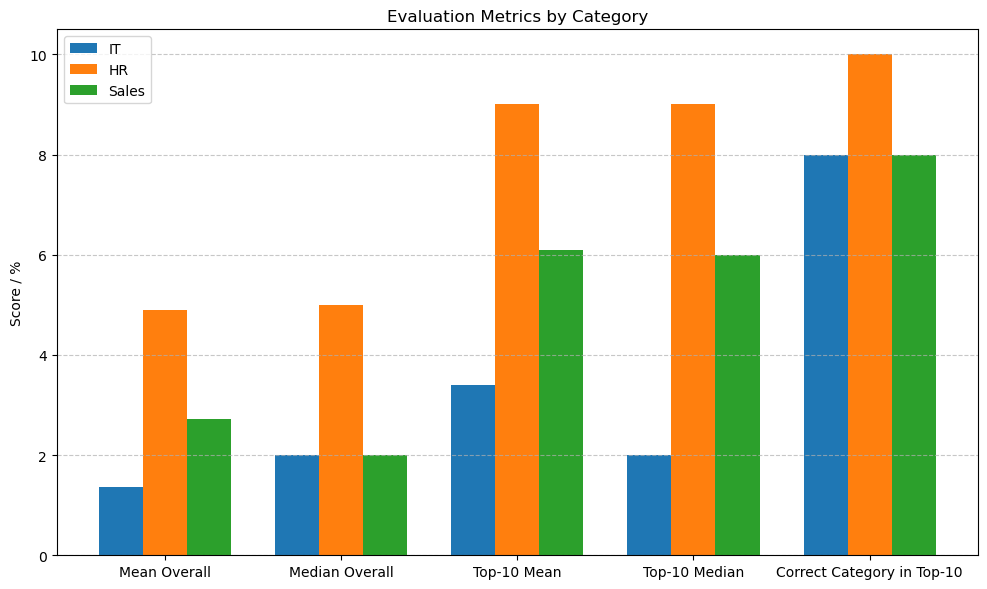

In [63]:
# Show chart
# Labels and setup
metric_labels = ['Mean Overall', 'Median Overall', 'Top-10 Mean', 'Top-10 Median', 'Correct Category in Top-10']
categories = ['IT', 'HR', 'Sales']
x = range(len(metric_labels))

# Create bar chart
width = 0.25
plt.figure(figsize=(10, 6))
plt.bar([p - width for p in x], metrics_it, width=width, label='IT')
plt.bar(x, metrics_hr, width=width, label='HR')
plt.bar([p + width for p in x], metrics_sales, width=width, label='Sales')

# Finalize chart
plt.xticks(x, metric_labels)
plt.ylabel('Score / %')
plt.title('Evaluation Metrics by Category')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()